# Degradation example with clearsky workflow


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
%matplotlib inline

#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

import rdtools

# 0. <b>PV System Metadata</b>

Collect data for the PV system under investigation.

In [2]:
# Metadata

meta = {"altitude":0,
        "latitude": -23.762028,
        "longitude": 133.874886,
        "Name": "Alice Springs",
        "State": "n/a",
        "TZ": 9.5,
        "timezone": 'Australia/North',
        "gcr": 0.3,
        "tempco": -0.005,
        "mounting": ['Fixed','Single-Axis'][0],
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback'}

# 1. <b>Standardize</b>

Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical columns.

The irradiance sensor data source is transposed to plane-of-array, and the temperature sensor data source is converted into estimated cell temperature.

The standardized `pandas.DataFrame` must contain the following column names:
* 'power', PV system power production in W or Wh
* 'poa', plane-of-array irradiance in W/m2
* 'Tamb', ambient temperature in degrees Celcius
* 'wind', [Optional] wind speed in m/s


C:\Users\gkimball\Envs\env_ecmwf\lib\site-packages\pvlib\irradiance.py:285: RuntimeWarning: invalid value encountered in maximum
  beam = np.maximum(beam, 0)


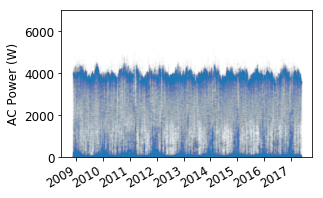

In [ ]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
df = df.rename(columns = {
    '12 BP Solar - Active Power (kW)':'power',
    '12 BP Solar - Wind Speed (m/s)': 'wind',
    '12 BP Solar - Weather Temperature Celsius (\xc2\xb0C)': 'Tamb',
    '12 BP Solar - Global Horizontal Radiation (W/m\xc2\xb2)': 'ghi',
    '12 BP Solar - Diffuse Horizontal Radiation (W/m\xc2\xb2)': 'dhi'
})



df.index = pd.to_datetime(df.Timestamp)
df.index = df.index.tz_localize(meta['timezone']) # TZ is required for irradiance transposition


# Chage power to watts
df['power'] = df.power * 1000.0 
# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# And then set the frequency of the dataframe
df = df.resample(freq).asfreq()

# Calculate energy yield in kWh
df['energy'] = df.power * pd.to_timedelta(df.power.index.freq).total_seconds()/(3600.0)

#generate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)

if meta['mounting'] == 'Single-Axis':    
    tr = pvlib.tracking.singleaxis(sun['apparent_zenith'],sun['azimuth'],
                                       meta['tilt'], meta['azimuth'], max_angle=45, backtrack=True, gcr=meta['gcr'])
    tilt = tr['surface_tilt']
    azimuth = tr['surface_azimuth']
else:
    tilt = meta['tilt']
    azimuth = meta['azimuth']

# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(tilt, df.dhi)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(tilt, azimuth, sun.zenith, sun.azimuth, df.dni)
df['poa'] = beam + sky

# Calculate temperature
df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model = meta['temp_model'])
df['Tcell'] = df_temp.temp_cell



# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.power, 'o', alpha = 0.01)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

In [ ]:
#PVWatts normalization with sensors

pvwatts_kws = {"poa_global" : df.poa,
              "P_ref" : meta['pdc'],
              "T_cell" :df.Tcell,
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : meta['tempco']}

normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)

df['normalized'] = normalized
df['insolation'] = insolation



#PVWatts normalization with clear sky models

loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)

if meta['mounting'] == 'Single-Axis':    
    tr = pvlib.tracking.singleaxis(sun['apparent_zenith'],sun['azimuth'],
                                       meta['tilt'], meta['azimuth'], max_angle=45, backtrack=True, gcr=0.3)
    tilt = tr['surface_tilt']
    azimuth = tr['surface_azimuth']
else:
    tilt = meta['tilt']
    azimuth = meta['azimuth']

# Calculate the clear sky POA irradiance
clearsky = loc.get_clearsky(df.index, solar_position = sun)
cs_sky = pvlib.irradiance.isotropic(tilt, clearsky.dhi)
cs_beam = pvlib.irradiance.beam_component(tilt, azimuth, sun.zenith, sun.azimuth, clearsky.dni)
df['clearsky_poa'] = cs_beam + cs_sky

# Calculate the clearsky temperature
df['clearsky_Tamb'] = rdtools.get_clearsky_tamb(df.index, meta['latitude'], meta['longitude'], meta['TZ'])
df_clearsky_temp = pvlib.pvsystem.sapm_celltemp(df.clearsky_poa, 0, df.clearsky_Tamb, model = meta['temp_model'])
df['clearsky_Tcell'] = df_clearsky_temp.temp_cell



clearsky_pvwatts_kws = {"poa_global" : df.clearsky_poa,
              "P_ref" : meta['pdc'],
              "T_cell" :df.clearsky_Tcell,
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : meta['tempco']}

clearsky_normalized, clearsky_insolation = rdtools.normalize_with_pvwatts(df.energy, clearsky_pvwatts_kws)

df['clearsky_normalized'] = clearsky_normalized
df['clearsky_insolation'] = clearsky_insolation


df.to_csv(r"inspect_fx.csv")

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

fig, ax = plt.subplots()
ax.plot(clearsky_normalized.index, clearsky_normalized, 'o', alpha = 0.05)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


In [ ]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future
filter_criteria = ((df['normalized']>0) & (df.poa>200) & (df.poa<1200))

filtered = df[filter_criteria]
filtered = filtered[['insolation', 'normalized']]

# Perform clearsky filter
csi_mask = rdtools.csi_filter(df.insolation, df.clearsky_insolation)
clearsky_filtered = df[(df['clearsky_normalized']>0) & (df.poa>200) & (df.poa<1200) & csi_mask]

# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# Plot the clearsky filtered power time series
fig, ax = plt.subplots()
ax.plot(clearsky_filtered.index, clearsky_filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 4. <b>Aggregate</b>

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

In [ ]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation)

clearsky_daily = rdtools.aggregation_insol(clearsky_filtered.normalized, clearsky_filtered.insolation)

# Plot the normalized and filtered power time series along with the aggregation
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# Plot the clearsky normalized and filtered power time series along with the aggregation
fig, ax = plt.subplots()
ax.plot(clearsky_filtered.index, clearsky_filtered.normalized, 'o', alpha = 0.05)
ax.plot(clearsky_daily.index, clearsky_daily, 'o', alpha = 0.1)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 5. <b>Degradation calculation</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.


In [ ]:
ols_rd, ols_ci, ols_info = rdtools.degradation_ols(daily)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (ols_rd, ols_ci[0], ols_ci[1])

yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily)
print '''The degradation rate calculated with year on year is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (yoy_rd, yoy_ci[0], yoy_ci[1])

In [ ]:
# Clearsky degradation
cs_ols_rd, cs_ols_ci, cs_ols_info = rdtools.degradation_ols(clearsky_daily)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (cs_ols_rd, cs_ols_ci[0], cs_ols_ci[1])

cs_yoy_rd, cs_yoy_ci, cs_yoy_info = rdtools.degradation_year_on_year(clearsky_daily)
print '''The degradation rate calculated with year on year is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (cs_yoy_rd, cs_yoy_ci[0], cs_yoy_ci[1])

In [ ]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')
ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# plot the clearsky regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(clearsky_daily.index, clearsky_daily, 'o', alpha = 0.1)
x_vals = np.array(ax.get_xlim())
y_vals = cs_ols_info['intercept'] + cs_ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')
ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [ ]:
# Plot the year-on-year distribution
# Note that the uncertainty is from bootstrapping the median
# not the standard deviation of the plotted distribution
fig, ax = plt.subplots()
yoy_values = yoy_info['YoY_values']
plt.hist(yoy_values, alpha=0.5, label='YOY', bins=int(yoy_values.__len__()/20))
plt.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
#plt.legend(loc='upper right')
plt.title('Year-on-Year Distribution')   
plt.tight_layout(w_pad=1, h_pad=2.0)
plt.xlabel('Annual degradation (%)');

# Plot the clearsky year-on-year distribution
# Note that the uncertainty is from bootstrapping the median
# not the standard deviation of the plotted distribution
fig, ax = plt.subplots()
cs_yoy_values = cs_yoy_info['YoY_values']
plt.hist(cs_yoy_values, alpha=0.5, label='YOY', bins=int(cs_yoy_values.__len__()/20))
plt.axvline(x=cs_yoy_rd, color='black', linestyle='dashed', linewidth=3)
#plt.legend(loc='upper right')
plt.title('Year-on-Year Distribution')   
plt.tight_layout(w_pad=1, h_pad=2.0)
plt.xlabel('Annual degradation (%)');